# How to break a neural network


We're going to use neural networks to make correct predictions!

THEN WE'RE GOING TO BREAK THEM.

In [166]:
# a bajillion imports
import shutil
import requests
import tempfile
import os
caffe_root = '/opt/caffe/'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.mpl_style', 'default')
%matplotlib inline

caffe_root = '/opt/caffe/'

import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Load the labels (so we know whether 242 means 'adorable puppy' or 'garbage can')
imagenet_labels_filename = caffe_root + '/data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !/opt/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

In [3]:
# Set Caffe to CPU mode because who even knows how to set up a GPU (not me)
caffe.set_mode_cpu()

# Load our model! trained by the GOOGLES! <3
def load_model():
    BATCH_SIZE = 1
    net = caffe.Net('/opt/caffe/models/bvlc_googlenet/deploy.prototxt',
                    '/models/bvlc_googlenet.caffemodel',
                    caffe.TEST)
    # change batch size to 1 for faster processing
    # this just means that we're only processing one image at a time instead of like 50
    shape = list(net.blobs['data'].data.shape)
    shape[0] = BATCH_SIZE
    net.blobs['data'].reshape(*shape)
    net.blobs['prob'].reshape(BATCH_SIZE, )
    net.reshape() 
    return net
net = load_model()
# Caffe comes with a handy transformer pipeline so that
# we can make our images into the format it needs! Yay!
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

If we're going to look at pictures of adorable dogs & pandas, we need a way to download them from the internet! This does that, and saves it to a png on our disk.

In [4]:
def get_png_image(url):
    fd, path = tempfile.mkstemp()
    tmpfile = os.fdopen(fd, "wb")
    response = requests.get(url, stream=True)
    shutil.copyfileobj(response.raw, tmpfile)
    if 'png' in url:
        !mv {path} {path}.png
    else:
        !convert {path} {path}.png
    path = path + ".png"
    return transformer.preprocess('data', caffe.io.load_image(path))

Now, let's start with a simple classification. We feed in the image (with some preprocessing) and classify with a forward pass.

In [5]:
cat_data = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))

In [6]:
print cat_data.shape

(3, 224, 224)


Great! The 3 means RGB, and the image is 224x224 pixels.

In [7]:
net.blobs['data'].data[...] = cat_data
out = net.forward()
pred_class = out['prob'][0].argmax()
print("Predicted class is #{}.".format(pred_class))

Predicted class is #282.


What did the input look like?

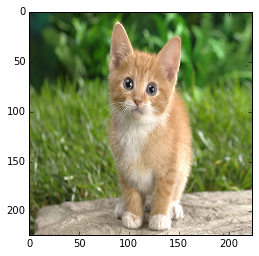

In [8]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

Adorable, but was our classification correct?

In [9]:
print labels[pred_class]

n02123159 tiger cat


Looks right! Let's put all that together into a couple of functions -- `predict()` will make a prediction & show the image.

In [107]:
def display(data):
    plt.imshow(transformer.deprocess('data', data))

def get_label_name(num):
    options = labels[num].split(',')
    # remove the tag
    options[0] = ' '.join(options[0].split(' ')[1:])
    return ','.join(options[:2])
    
def predict(data, n_preds=6, display_output=True):
    net.blobs['data'].data[...] = data
    if display_output:
        display(data)
    prob = net.forward()['prob']
    probs = prob[0]
    prediction = probs.argmax()
    top_k = probs.argsort()[::-1]
    for pred in top_k[:n_preds]:
        percent = round(probs[pred] * 100, 2)
        # display it compactly if we're displaying more than the top prediction
        pred_formatted = "%03d" % pred
        if n_preds == 1:
            format_string = "label: {cls} ({label})\ncertainty: {certainty}%"
        else:
            format_string = "label: {cls} ({label}), certainty: {certainty}%"
        if display_output:
            print format_string.format(
                cls=pred_formatted, label=get_label_name(pred), certainty=percent)
    return prob

label: 388 (giant panda, panda)
certainty: 99.57%


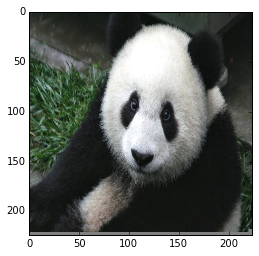

In [108]:
panda_url = 'https://upload.wikimedia.org/wikipedia/commons/c/cd/Panda_Cub_from_Wolong,_Sichuan,_China.JPG'
panda_data = get_png_image(panda_url)
probs = predict(panda_data, n_preds=1)

class: 412
label: ashcan, trash can
certainty: 40.58%


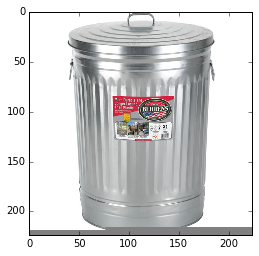

In [105]:
garbage_url = 'http://www.behrensmfg.com/wp-content/uploads/1270-31-gallon-trash-can.jpg'
garbage_data = get_png_image(garbage_url)
probs = predict(garbage_data, n_preds=1)

class: 623
label: n03658185 letter opener, paper knife, paperknife
certainty: 77.63%


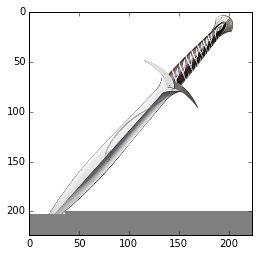

In [13]:
sword_url = 'http://a.tgcdn.net/images/products/zoom/f2bc_sting_the_sword_of_bilbo_baggins.jpg'
sword_data = get_png_image(sword_url)
probs = predict(sword_data, n_preds=1)

class: 285
label: n02124075 Egyptian cat
certainty: 34.57%


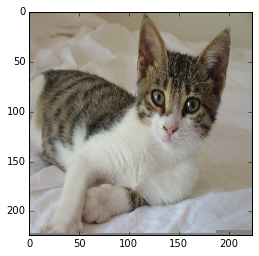

In [14]:
kitten_url = 'https://upload.wikimedia.org/wikipedia/commons/b/b9/CyprusShorthair.jpg'
kitten_data = get_png_image(kitten_url)
probs = predict(kitten_data, n_preds=1)

class: 263
label: n02113023 Pembroke, Pembroke Welsh corgi
certainty: 42.77%


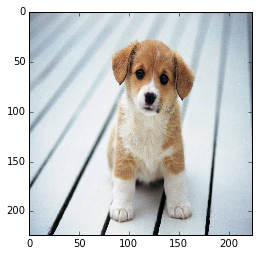

In [15]:
dog_url = 'http://cdn.playbuzz.com/cdn/7820ec56-cd7d-487c-87ba-30ca87219dc4/26084bf6-4235-4f8f-9c2f-b7294ea62c15.jpg'
dog_data = get_png_image(dog_url)
probs = predict(dog_data, n_preds=1)

class: 793
label: n04209133 shower cap
certainty: 99.7%


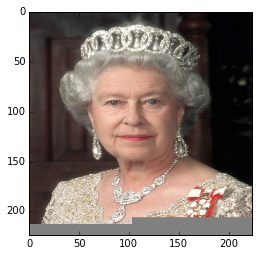

In [16]:
queen_url = 'http://www.librarising.com/astrology/celebs/images2/QR/queenelizabethii.jpg'
queen_data = get_png_image(queen_url)
probs = predict(queen_data, n_preds=1)

Here's a good example where the network has 2 options it's about equally sure of:

label: 716 (picket fence, paling), certainty: 63.82%
label: 912 (worm fence, snake fence), certainty: 36.12%
label: 646 (maze, labyrinth), certainty: 0.01%
label: 753 (radiator), certainty: 0.01%
label: 888 (viaduct), certainty: 0.01%
label: 825 (stone wall), certainty: 0.0%


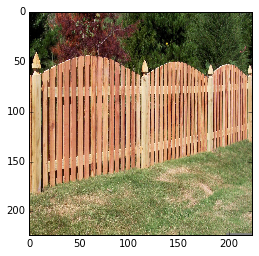

In [109]:
fence_url = 'http://jmarvinhandyman.com/wp-content/uploads/2014/04/fence-mossy-oak-wood-shadowbox_1373304.jpg'
fence_data = get_png_image(fence_url)
probs = predict(fence_data, n_preds=6)

# Intentionally breaking the predictions.

Now it's time for the fun part. When is a garbage can not a garbage can?

When it's a cocktail shaker, or a water jug.

When is a panda not a panda?

When it's another furry mammal. Let me show you what I mean and stop making silly jokes. We're going to start with the simplest possible image: one that's totally black.

In [18]:
net = load_model()

## Step 1: the black screen

label: 885 (velvet), certainty: 27.38%
label: 794 (shower curtain), certainty: 6.4%
label: 911 (wool, woolen), certainty: 6.19%
label: 700 (paper towel), certainty: 4.67%
label: 904 (window screen), certainty: 4.39%


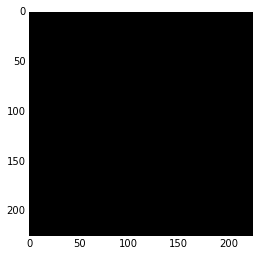

In [113]:
black = np.zeros_like(grad)
_ = predict(black, n_preds=5)

## Step 2: calculate the gradient

No big deal. Now, let's calculate the gradient of the network there! In order to do that, we need to decide what the black screen is actually "supposed" to be. I'm going to go ahead and tell the network it was supposed to be a paper towel: label 700.

We compute the gradient using something called 'backpropagation'. The gradient is the direction which would move the image most towards being a paper towel.

In [118]:
def compute_gradient(intended_outcome):
    # Get an empty set of probabilities
    probs = np.zeros_like(net.blobs['prob'].data)
    # Set the probability for our intended outcome to 1
    probs[0][intended_outcome] = 1
    # Do backpropagation to calculate the gradient for that outcome
    gradient = net.backward(prob=probs)
    return gradient['data'].copy()

In [144]:
grad = compute_gradient(700)

What does it look like? Because the gradient is the same shape as the the original image, we can just display it as an image!. We need to scale it up to make it really visible though.

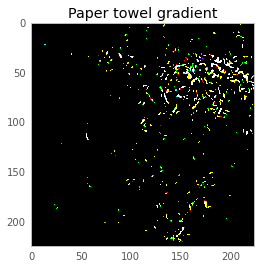

In [167]:
display(grad / np.percentile(grad, 98))
plt.title('Paper towel gradient')

## Step 3: find the direction that makes it most like a paper towel

Okay, now here's the trick. We want to maximize the amount we're going to change our output probabilities by. Near our image, the probabilities look like

$$ P(x + \text{delta}) =  P(x) + \text{delta} \cdot \text{grad}$$

where the gradient `grad` is $\nabla P(x)$. So we want to maximize the dot product of the direction we're moving `delta` and the gradient `grad`. We've already calculated `grad` via our `compute_gradient()` function, and drawn it as a picture.

The intuition behind what we want to do is -- we want to create a `delta` which emphasizes the pixels in the picture that the neural network thinks is important. Let's do it in code now, and hopefully what we're doing will become here.

<small>
(I'm lying a little here -- what we're trying to manipulate isn't actually the probabilities directly, but instead something called the *loss function*. But the idea is the same.)
</small>

First, let's pick a random direction and see what $ \text{delta} \cdot \text{grad} $ is

In [146]:
delta_random = np.random.randint(-1, 1, grad.shape)
np.sum(grad * delta_random)

0.00041306844016553157

So that's a pretty small change in probability. Now, let's suppose `grad` was $(-0.01, -0.01, 0.01, 0.02, 0.03)$.

We could make $\text{grad} \cdot \text{delta}$ big by taking $\text{delta} = (-1, -1, 1, 1, 1)$, to get 0.08. Let's try that! In code, that'll be `delta = np.sign(grad)`

In [147]:
delta = np.sign(grad)
np.sum(grad * delta)

1.1368587

That's much more significant! Like, more than 10%! Let's see if adding that delta to our image makes a big change in the classification.

In [148]:
net = load_model()

## Step 4: did it work (yes!)

label: 885 (velvet), certainty: 54.75%
label: 700 (paper towel), certainty: 16.03%
label: 911 (wool, woolen), certainty: 12.4%
label: 533 (dishrag, dishcloth), certainty: 2.65%
label: 794 (shower curtain), certainty: 2.11%


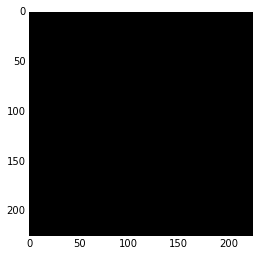

In [150]:
_ = predict(black + 0.9*delta, n_preds=5)

It still thinks that this is velvet, but the probability that it's a paper towel has gone up from 4% to 16%. So we've made a pretty significant change! We can take this a little further and move the image several small steps in a loop:

## Step 5: do it in a loop, so it works even better

In [160]:
black = np.zeros_like(panda_data)
# maintain a list of outputs at each prediction
prediction_steps = []
for _ in range(9):
    grad = compute_gradient(700) # paper towel
    delta = np.sign(grad)
    black = black + delta * 0.1
    preds = predict(black, display_output=False)
    prediction_steps.append(np.copy(preds))

### See the probabilities change over time

Let's make a graph! Graphs are the best.

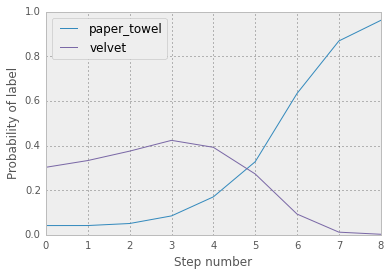

In [165]:
velvet_label = 885
paper_towel_label = 700
df = pd.DataFrame({
    'velvet': [s[0][velvet_label] for s in prediction_steps],
    'paper_towel': [s[0][paper_towel_label] for s in prediction_steps]
    })

df.plot()
plt.xlabel('Step number')
plt.ylabel('Probability of label')

label: 700 (paper towel), certainty: 96.06%
label: 434 (bath towel), certainty: 1.14%


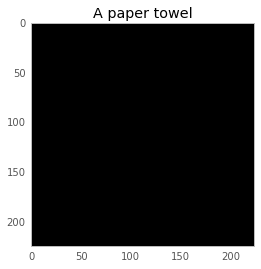

In [175]:
_ = predict(black, n_preds=2)
plt.title('A paper towel')

### The pixel values
And here are the pixel values that make up that image! They all started out at exactly 0, and you can see that we've mutated them to be small but powerful in tricking the network to think the image is a paper towel.

In [169]:
black

array([[[[-0.5       , -0.1       ,  0.30000001, ..., -0.5       ,
          -0.30000001, -0.09999999],
         [-0.5       , -0.9000001 , -0.5       , ...,  0.5       ,
           0.1       , -0.70000005],
         [-0.30000001, -0.5       , -0.5       , ...,  0.10000002,
           0.1       , -0.70000005],
         ..., 
         [-0.1       , -0.1       , -0.30000001, ..., -0.5       ,
          -0.1       ,  0.70000005],
         [-0.09999999, -0.70000005, -0.70000005, ...,  0.1       ,
          -0.30000001, -0.70000005],
         [-0.70000005, -0.9000001 , -0.70000005, ...,  0.70000005,
           0.1       , -0.30000001]],

        [[-0.30000001, -0.1       ,  0.1       , ..., -0.1       ,
           0.10000002,  0.30000001],
         [-0.09999999, -0.5       , -0.5       , ..., -0.1       ,
          -0.30000001, -0.70000005],
         [ 0.10000002, -0.30000001, -0.30000001, ...,  0.10000002,
          -0.30000001, -0.70000005],
         ..., 
         [-0.1       ,  0.300000

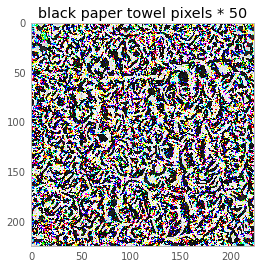

In [176]:
display(black * 50)
plt.title('black paper towel pixels * 50')

# Having fun tricking the neural network:

We're going to create a little function to trick the network into believing our fuzzy animals are other fuzzy animals. It's the same as what we did for the black screen and the paper towel, except a little more configurable. We let it choose the number of steps like 1 or 100 -- 100 will be more effective but slower.

In [234]:
def trick(image, desired_output, n_steps=1):
    # maintain a list of outputs at each step
    prediction_steps = []
    for _ in range(n_steps - 1):
        preds = predict(image, display_output=False)
        prediction_steps.append(np.copy(preds))
        grad = compute_gradient(desired_output) # paper towel
        delta = np.sign(grad)
        # If there are n steps, we make them size 1/n -- small!
        image = image + delta * 0.9 / n_steps
    return image, prediction_steps

### panda

label: 388 (giant panda, panda), certainty: 99.57%
label: 387 (lesser panda, red panda), certainty: 0.1%
label: 383 (Madagascar cat, ring-tailed lemur), certainty: 0.05%
label: 850 (teddy, teddy bear), certainty: 0.04%
label: 356 (weasel), certainty: 0.03%


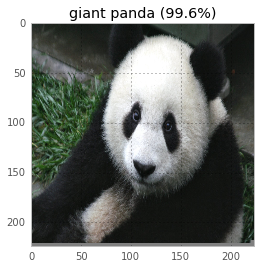

In [343]:
_  = predict(panda_data, n_preds=5)
plt.title("giant panda (99.6%)")

What happens if we make it **less** like a panda? It becomes 40% weasel! And the neat thing is that -- we can do that in a single step, by adding just one image. This is what's meant by 'neural networks are kind of linear'.

label: 356 (weasel), certainty: 25.94%
label: 358 (polecat, fitch), certainty: 21.93%
label: 359 (black-footed ferret, ferret), certainty: 21.88%


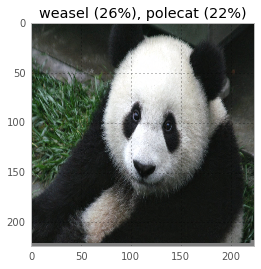

In [292]:
panda_label = 388
_ = predict(panda_data, display_output=False)
grad = compute_gradient(panda_label)
delta = np.sign(grad)
_ = predict(panda_data - 0.9 * delta, n_preds=3) # less like a panda, not more!
plt.title("weasel (26%), polecat (22%)")

Let's put this code for making a panda less like a panda into a function. We'll be using it again.

In [299]:
def make_less_like(image, label):
    panda_label = 388
    _ = predict(image, display_output=False)
    grad = compute_gradient(label)
    delta = np.sign(grad)
    return grad, image - 0.9 * delta

## Making the panda a vulture

We run our `trick` function with 100 steps -- making a panda into a vulture is complicated! But worthwhile

In [235]:
vulture_label=23
vulture_panda, steps = trick(panda_data, vulture_label, n_steps=100)

label: 023 (vulture), certainty: 98.88%
label: 009 (ostrich, Struthio camelus), certainty: 0.2%
label: 368 (gibbon, Hylobates lar), certainty: 0.16%
label: 146 (albatross, mollymawk), certainty: 0.15%
label: 383 (Madagascar cat, ring-tailed lemur), certainty: 0.09%
label: 134 (crane), certainty: 0.07%


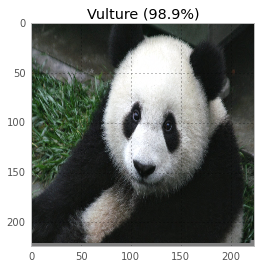

In [290]:
_ = predict(vulture_panda)
plt.title("Vulture (98.9%)")

I put together a 

In [242]:
def plot_steps(steps, label_list, **args):
    d = {}
    for label in label_list:
        d[get_label_name(label)] = [s[0][label] for s in steps]
    df = pd.DataFrame(d)
    df.plot(**args)
    plt.xlabel('Step number')
    plt.ylabel('Probability of label')

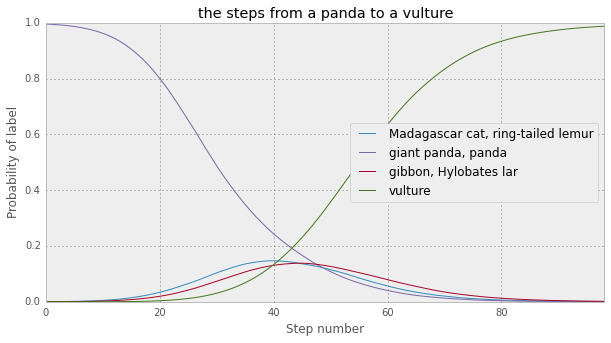

In [258]:
plot_steps(steps, [23, 388, 368, 383], figsize=(10, 5))
plt.title("the steps from a panda to a vulture")

## The garbage can

label: 412 (ashcan, trash can), certainty: 40.58%
label: 899 (water jug), certainty: 11.03%
label: 503 (cocktail shaker), certainty: 7.03%


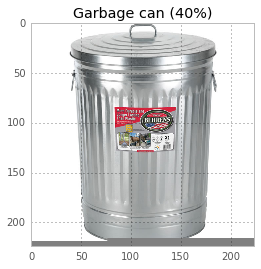

In [297]:
_ = predict(garbage_data, n_preds=3)
plt.title("Garbage can (40%)")

label: 899 (water jug), certainty: 25.14%
label: 503 (cocktail shaker), certainty: 14.93%
label: 505 (coffeepot), certainty: 12.25%
label: 898 (water bottle), certainty: 6.79%


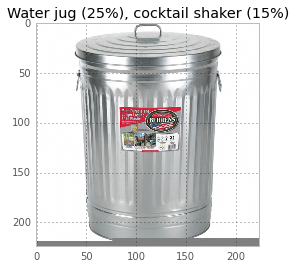

In [300]:
grad, image = make_less_like(garbage_data, 412)
_ = predict(image, n_preds=4)
plt.title("Water jug (25%), cocktail shaker (15%)")

And here's the gradient:

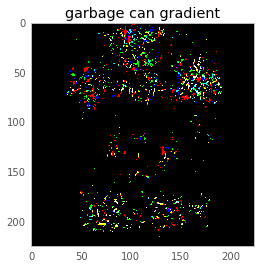

In [304]:
display(grad / np.percentile(grad, 98))
plt.title("garbage can gradient")

We can also make the network **more** sure it's a garbage can:

label: 412 (ashcan, trash can), certainty: 84.66%
label: 463 (bucket, pail), certainty: 2.85%


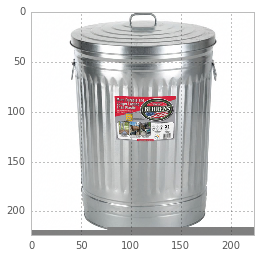

In [315]:
_ = predict(garbage_data + 0.75 * np.sign(grad), n_preds=2)

### Kitten

label: 285 (Egyptian cat), certainty: 34.57%
label: 281 (tabby, tabby cat), certainty: 32.59%
label: 282 (tiger cat), certainty: 15.58%
label: 896 (washbasin, handbasin), certainty: 1.99%
label: 287 (lynx, catamount), certainty: 1.94%
label: 876 (tub, vat), certainty: 1.93%


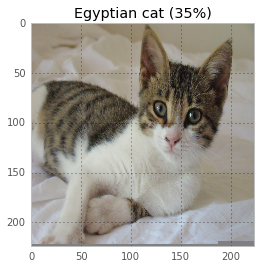

In [342]:
_ = predict(kitten_data)
plt.title("Egyptian cat (35%)")

Now, we make each of the top 3 predictions less likely!

In [322]:
grad, image = make_less_like(kitten_data, 285)
grad, image2 = make_less_like(image, 281)
grad, image3 = make_less_like(image, 282)

label: 434 (bath towel), certainty: 49.57%
label: 700 (paper towel), certainty: 11.03%
label: 896 (washbasin, handbasin), certainty: 8.89%
label: 999 (toilet tissue, toilet paper), certainty: 4.96%
label: 876 (tub, vat), certainty: 4.38%
label: 435 (bathtub, bathing tub), certainty: 2.71%


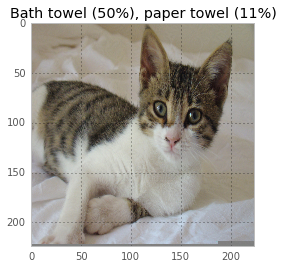

In [325]:
_ = predict(image3)
plt.title("Bath towel (50%), paper towel (11%)")

### Dog

This dog, on the other hand, is highly resistant to being classified as something other than a dog. When we subtract away the corgi and beagle it just insists "maybe a golden retriever then!" I spent some time trying to convince it that the dog was a tennis ball but it remained, well, a dog.

good job, network (so far!)

label: 263 (Pembroke, Pembroke Welsh corgi), certainty: 42.77%
label: 162 (beagle), certainty: 26.07%
label: 264 (Cardigan, Cardigan Welsh corgi), certainty: 14.57%
label: 207 (golden retriever), certainty: 3.35%
label: 151 (Chihuahua), certainty: 2.58%
label: 156 (Blenheim spaniel), certainty: 2.03%


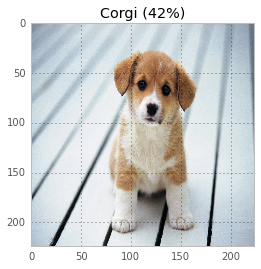

In [340]:
_ = predict(dog_data)
plt.title("Corgi (42%)")

In [331]:
grad, image = make_less_like(dog_data, 263)
grad, image2 = make_less_like(image, 162)
grad, image3 = make_less_like(image2, 264)
grad, image4 = make_less_like(image2, 167)

label: 207 (golden retriever), certainty: 40.72%
label: 215 (Brittany spaniel), certainty: 28.2%
label: 219 (cocker spaniel, English cocker spaniel), certainty: 4.95%
label: 156 (Blenheim spaniel), certainty: 4.34%
label: 265 (toy poodle), certainty: 3.98%
label: 185 (Norfolk terrier), certainty: 1.99%


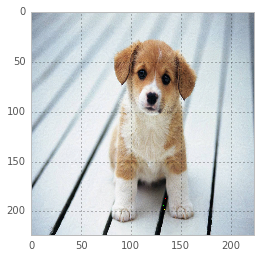

In [335]:
_ = predict(image4)

### 